<a href="https://colab.research.google.com/github/mredelis/CAP4453-Robot-Vision-Spr23/blob/main/RV_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CAP4453: Robot Vision
###Project 1: Python program that rectifies images from documents


####Part 1

The manual part of the project (Part 1) uses auxiliary functions from homework 5 listed below.

1. `H = computeH(im1_pts,im2_pts)`
<br>
* Where `im1_pts` and `im2_pts` are n-by-2 matrices holding the (x,y) locations of n point correspondences from the two images and H is the recovered 3x3 homography matrix.
<br>
* The method solves an expression of the form $Ax=b$ shown below if $h_{22}=1$ </b>

\begin{align}
        \begin{pmatrix}
        x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1^{\prime}x_1 & -x_1^{\prime}y_1 \\
        0 & 0 & 0 & x_1 & y_1 & 1 & -y_1^{\prime}x_1 & -y_1^{\prime}y_1 \\
        .\\
        .\\
        .\\
        x_n & y_n & 1 & 0 & 0 & 0 & -x_n^{\prime}x_n & -x_n^{\prime}y_n \\
        0 & 0 & 0 & x_n & y_n & 1 & -y_n^{\prime}x_n & -y_n^{\prime}y_n \\
        \end{pmatrix}
        \begin{pmatrix}
        h_{00}\\
        h_{01}\\
        h_{02}\\
        h_{10}\\
        h_{11}\\
        h_{12}\\
        h_{20}\\
        h_{21}\\       
        \end{pmatrix} = 
        \begin{pmatrix}
        x_1^{\prime}\\
        y_1^{\prime}\\
        .\\
        .\\
        .\\
        x_n^{\prime}\\
        y_n^{\prime}\\
        \end{pmatrix}
    \end{align}

<br><br>

2. `imwarped = warpImage(im,H,limit_coordinates)`
<br>
* Where im is the input image to be warped, H is the homography, and limit_coordinates defines the limits (xmin,xmax,ymin,ymax) of the warped image.
* Note that this function takes computational time and to speed up the process of backward warping, the opencv method was used as instructed in the project. 

In [ ]:
from skimage import io

# Function that computes the homography matrix
def computeH(im1_pts, im2_pts):
  # matrices must have shame shape
  if(im1_pts.shape != im2_pts.shape):
    return

  numPoints = im1_pts.shape[0]
  
  # Each point gives two equations (two rows in the A and b matrices)
  A = np.zeros((2*numPoints, 8))
  b = np.zeros((2*numPoints, 1))

  # fill matrix A and column vector b
  for i in range(numPoints):
    A[2*i,:] = [im1_pts[i,0], im1_pts[i,1], 1, 0, 0, 0, -im2_pts[i,0]*im1_pts[i,0], -im2_pts[i,0]*im1_pts[i,1]]
    A[2*i+1,:] = [0, 0, 0, im1_pts[i, 0], im1_pts[i, 1], 1, -im2_pts[i,1]*im1_pts[i,0], -im2_pts[i,1]*im1_pts[i,1]]

    b[2*i,:] = im2_pts[i,0]
    b[2*i+1,:] = im2_pts[i,1]

  # least squares solution to Ax=b
  x,residuals,rank,s = np.linalg.lstsq(A, b, rcond=None)

  # the expression was obtained when h22=1. Append this value to the x solution
  x = np.append(x, [[1]], axis=0)
  # print(f"x matrix:\n{x}")
  # print(x.shape)

  H = np.reshape(x, (3,3))

  return H


def warpImage(im, H, limit_coordinates):

  i = np.linspace(0, img.shape[0]-1, img.shape[0]).astype(int)
  j = np.linspace(0, img.shape[1]-1, img.shape[1]).astype(int)
  yv, xv = np.meshgrid(i, j)

  numpoints = xv.ravel().shape[0]

  # extract the color channels
  r = img[yv.ravel(),xv.ravel(),0]
  g = img[yv.ravel(),xv.ravel(),1]
  b = img[yv.ravel(),xv.ravel(),2]

  # all the values of x coordinates as a row
  x_cord = xv.ravel().reshape((1,numpoints))
  # all the values of y coordinates as a row
  y_cord = yv.ravel().reshape((1,numpoints))

  # define the homogeneous coordinates
  grid = np.concatenate((x_cord, y_cord, np.ones((1,numpoints))),axis=0)

  # transform the grid (your canvas) in the new coordinated determined by the homography defined below
  newgrid = np.matmul(H, grid)

  # Convert from homogeneous to heterogeneous coordinates
  newgridHetero = newgrid[:2,:]   # the x, and y
  thethirdcoordinate = newgrid[2,:]

  newgridHetero[0,:]= newgridHetero[0,:] / thethirdcoordinate
  newgridHetero[1,:]= newgridHetero[1,:] / thethirdcoordinate

  # define your new empty canvas (it will have -1 if is not defined)
  # limit_coordinates defines the limits (xmin,xmax,ymin,ymax)
  x_span = np.abs(limit_coordinates[1]-limit_coordinates[0]) + 1
  y_span = np.abs(limit_coordinates[3]-limit_coordinates[2]) + 1

  warped = -np.ones((y_span,x_span,3)).astype(np.int16)

  # Raw approximation. Considering just the integer values 
  newgrid2 = newgridHetero.round().astype(np.int64)

  # only consider points that are in your area of interest (0 to 1000)
  validsX=np.bitwise_and(newgrid2[0,:]>=limit_coordinates[0],newgrid2[0,:]<limit_coordinates[1])
  validsY=np.bitwise_and(newgrid2[1,:]>=limit_coordinates[2],newgrid2[1,:]<limit_coordinates[3])
  valids = np.bitwise_and(validsX,validsY)

  # assign color to the pixels that are valids
  warped[newgrid2[1,valids],newgrid2[0,valids],0] = r[valids]
  warped[newgrid2[1,valids],newgrid2[0,valids],1] = g[valids]
  warped[newgrid2[1,valids],newgrid2[0,valids],2] = b[valids]

  # nearest Neighbor interpolation
  # new canvas
  warped2 = np.zeros((y_span,x_span,3)).astype(np.uint8)
  # Area where we look for closest valid assignation
  area2check=5

  # loop over the valid area of the warped image
  for i in range(area2check,warped.shape[0]-area2check):
      for j in range(area2check,warped.shape[1]-area2check):
          # check if the pixel has a valid warped value        
          if warped[i,j,0]==-1:  #need to look for neighbor
              distance = area2check*area2check+1  # assign a distance larger than any that can be found in the area to check
              
              # loop over all the possible neighbors
              for k in range(i-area2check,i+area2check):
                  for l in range(j-area2check,j+area2check):
                      distancetested = (abs(k-i)+abs(l-j))  # L1 distance
                      if warped[k,l,0]>=0 and distancetested<distance:    # found a warped point , and it is closest
                          distance=distancetested
                          warped2[i,j]=warped[k,l]
          else:  #assign the valid warping
              warped2[i,j] = warped[i,j]

  return warped2

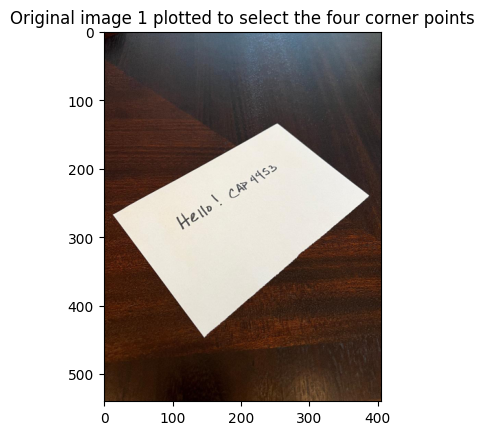

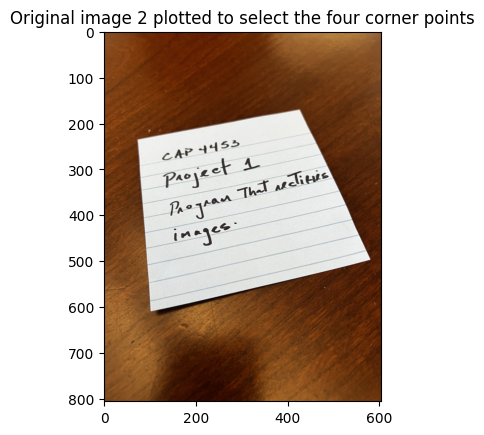

In [ ]:
# import the necessary packages
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage import io

# load images
url = "https://raw.githubusercontent.com/mredelis/CAP4453-Robot-Vision-Spr23/main/image.jpeg"
# url2 = "https://raw.githubusercontent.com/mredelis/CAP4453-Robot-Vision-Spr23/main/image2.jpeg"
url2 = "https://raw.githubusercontent.com/mredelis/CAP4453-Robot-Vision-Spr23/main/test1.jpeg"
img = io.imread(url)
img2 = io.imread(url2)

# resize images
# print('Original image  1 dimensions : ',img.shape)
# print('Original image  2 dimensions : ',img2.shape)
scale_percent = 50 #percent of original size
scale_percent2 = 20 #percent of original size

height = int(img.shape[0] * scale_percent / 100)
width = int(img.shape[1] * scale_percent / 100)
dim = (width, height)

height2 = int(img2.shape[0] * scale_percent2 / 100)
width2 = int(img2.shape[1] * scale_percent2 / 100)
dim2 = (width2, height2)

img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
img2 = cv.resize(img2, dim2, interpolation = cv.INTER_AREA)
# print('Resized image 1 dimensions: ',img.shape)
# print('Resized image 2 dimensions: ',img2.shape)
print()

# cv2_imshow(img)
# print()
# cv2_imshow(img2)
# print()

# Display images to have an idea of the corner points
# figure_size = plt.gcf().get_size_inches()
# factor = 5
# plt.gcf().set_size_inches(factor * figure_size)
# plt.xticks(np.arange(0, 405, 10))
# plt.yticks(np.arange(0, 540, 10))
plt.imshow(img)
plt.title("Original image 1 plotted to select the four corner points")
plt.show()

# figure_size = plt.gcf().get_size_inches()
# factor = 5
# plt.gcf().set_size_inches(factor * figure_size)
# plt.xticks(np.arange(0, 604, 20))
# plt.yticks(np.arange(0, 806, 10))
plt.imshow(img2)
plt.title("Original image 2 plotted to select the four corner points")
plt.show()


Please enter the corner points separated by a comma.

Suggested coordinates for image 1:
A:10, 265
B:148, 448
C:388, 240
D:255, 135

Enter top left corner point (A): 10,265
Enter bottom left corner point (B): 148,448
Enter bottom right corner point (C): 388,240
Enter top right corner point (D): 255,135

Suggested coordinates for image 2:
A:78, 235
B:102, 612
C:580, 500
D:428, 170

Enter top left corner point (A): 78,235
Enter bottom left corner point (B): 102,612
Enter bottom right corner point (C): 580,500
Enter top right corner point (D): 428,170

Rectified images



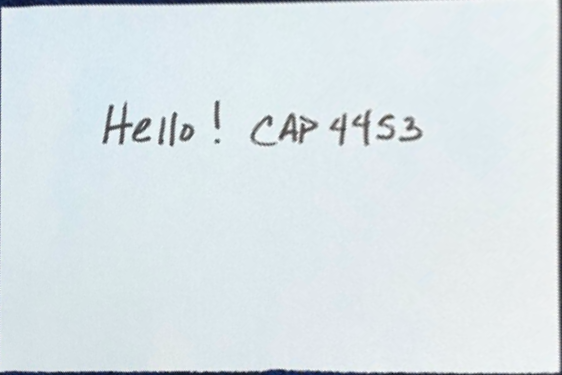

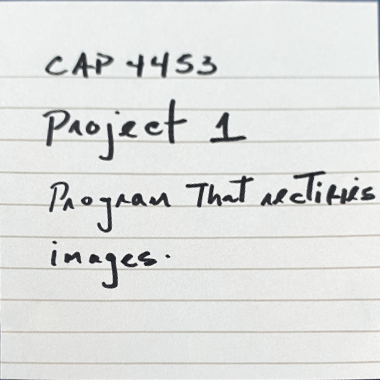

In [ ]:
# Manual Mode (80%)

# a. Provide user a way to select the 4 corner points. Input is read as string
print("\nPlease enter the corner points separated by a comma.\n")

print("Suggested coordinates for image 1:\nA:10, 265\nB:148, 448\nC:388, 240\nD:255, 135\n")
x1, y1 = input("Enter top left corner point (A): ").split(",")
x2, y2 = input("Enter bottom left corner point (B): ").split(",")
x3, y3 = input("Enter bottom right corner point (C): ").split(",")
x4, y4 = input("Enter top right corner point (D): ").split(",")

print()

print("Suggested coordinates for image 2:\nA:78, 235\nB:102, 612\nC:580, 500\nD:428, 170\n")
x1_2, y1_2 = input("Enter top left corner point (A): ").split(",")
x2_2, y2_2 = input("Enter bottom left corner point (B): ").split(",")
x3_2, y3_2 = input("Enter bottom right corner point (C): ").split(",")
x4_2, y4_2 = input("Enter top right corner point (D): ").split(",")

# user selected points casted to an int
img_src_pts = np.array([[int(x1),int(y1)],[int(x2), int(y2)],[int(x3), int(y3)],[int(x4),int(y4)]])
img_src_pts_2 = np.array([[int(x1_2),int(y1_2)],[int(x2_2), int(y2_2)],[int(x3_2), int(y3_2)],[int(x4_2),int(y4_2)]])

# Corners of the documents to be rectified. Uncomment if you don't want to enter the points manually and comment the input functions above
# img_src_pts = np.array([[10, 265], [148, 448], [388, 240], [255, 135]])
# img_src_pts_2 = np.array([[78, 235], [102, 612], [580, 500], [428, 170]])

# print(f"Image 1 four corner points:\n{img_src_pts}\n")
# print(f"Image 2 four corner points:\n{img_src_pts_2}\n")

# Destination canvas
img_dst_pts = np.array([[0,0],[0,750/2],[1125/2,750/2],[1125/2,0]])
img_dst_pts_2 = np.array([[0,0],[0,380],[380,380],[380,0]])


# b. Compute H (homography) using method of HW5
H = computeH(img_src_pts,img_dst_pts)
H2 = computeH(img_src_pts_2, img_dst_pts_2)

# using opencv to check the work
h, status = cv.findHomography(img_src_pts, img_dst_pts) 
h2, status = cv.findHomography(img_src_pts_2, img_dst_pts_2) 

# print(f"Homography (H) matrix manual method for Image 1:\n{H}\n")
# print(f"Homography (H) matrix with opencv for Image 1:\n{h}\n")
# print(f"Homography (H) matrix manual method for Image 2:\n{H2}\n")
# print(f"Homography (H) matrix with opencv for Image 2:\n{h2}\n")

# c. Perform backward warping using method of HW5. Test with opencv method to compare
# size (widht,height) of img_dst
size = (int(1125/2), int(750/2))
size2 = (380, 380)

# Using opencv
img_dst = cv.warpPerspective(img, H, size)
img_dst_2 = cv.warpPerspective(img2, H2, size2)

# Using method from homework 5
# limit_coord = [xmin,xmax,ymin,ymax]
# limit_coord = [0, int(1125/2), 0, int(750/2)]
# warped = warpImage(img, h, limit_coord)

# d. Show warped image
print("\nRectified images\n")
cv2_imshow(img_dst)
print()
cv2_imshow(img_dst_2)
print()

# print("Rectified image with manual method")
# cv2_imshow(warped)


####Part 2 Fully automated document recovery

In part 2, unlike part 1, the aim is to find the corners of the document automatically. After finding the coordinates of the corner points, it is necessary to calculate the width and the height of the document to compute the homography and backward warping.
<br>
The idea behind the method is to utilize the Harris Corner detector from OpenCV. The general steps are as follows:
<br>
- Load the image
- Do some preprocessing of the image before applying the corner detector. The image was resized with a scale factor of 40% for easy display, then converted to grayscale (the input image in Harris Corner Detector should be a grayscale), blurred with a gaussian filter to remove high-frequency noise, and performed edge detection with Canny from OpenCV. 
- Find the four corner point coordinates from the list of corners result from Harris
- A method `order_points(pts)` returns numpy array of the 4 corner coordinates and takes as an input the corners found by the Harris corner detector. <br>
The top-left corner will have the smallest sum of the array whereas the bottom-right corner will have the largest sum of the array and the top-right will have the smallest difference and bottom-left the largest difference. 
- Plot the 4 point corner coordinates on the image to test the results.
- Find the size of the new image. The new width is the maximum distance between the bottom-right and bottom-left x-coordinates or the top-right and top-left x-coordinates. The new height is the maximun distance between the top-right and bottom-right y-coordinates or the top-left and bottom-left y-coordinates.
- Find the transformation from input image to the rectified image.
- Apply the transformation using the new image size 

In [ ]:
def order_points(pts):
    # List of coordinates that will be ordered. 
    # The first entry in the list is the top-left, the second entry is the top-right, 
    # the third is the bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
  
    # top-left point has the smallest sum
    # bottom-right point has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # compute the difference between the points
    # top-right point will have the smallest difference,
    # bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [ ]:
def warpImg(image, pts):
    # obtain a consistent order of the points and unpack them individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # print(rect.shape)

    # Plot four corner points on the image
    x, y = rect[:, 0], rect[:, 1]
    for i in range(len(rect)):
      plt.plot(x[i], y[i], color="green", marker="o")
    plt.title("Four corner point coordinates on the image")
    plt.imshow(image)
    plt.show()

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left x-coord or the top-right and top-left x-coord
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right y-coord
    # or the top-left and bottom-left y-coord
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # construct the coordinates of the destination points
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

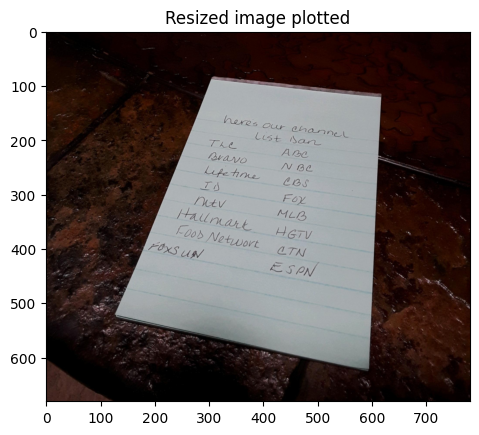

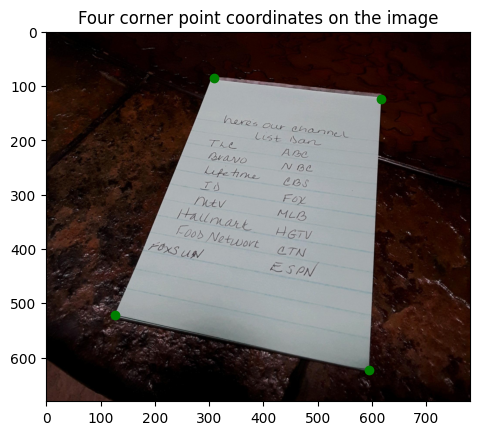


Fully automated document recovery


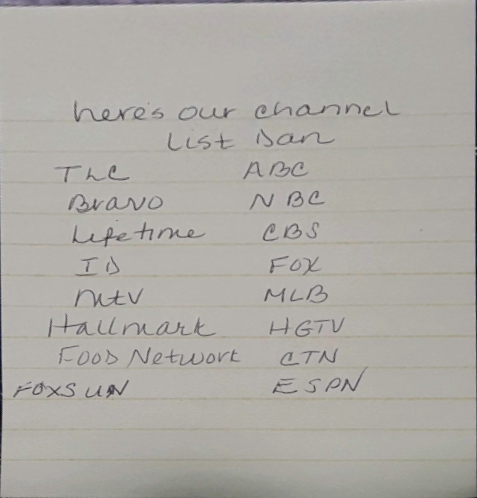

In [ ]:
# import the necessary packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage import io

# load image
url = "https://i.redd.it/bebi64i3kbb31.jpg"
image = io.imread(url)

# resize image
scale_pct = 40
height = int(image.shape[0] * scale_pct / 100)
width = int(image.shape[1] * scale_pct / 100)
dimensions = (width, height)
# print(dimensions)
image = cv2.resize(image, dimensions, interpolation = cv2.INTER_AREA)

plt.imshow(image)
plt.title("Resized image plotted")
plt.show()

# convert the image to grayscale, blur it to remove noise, and find edges with opencv Canny
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (13, 13), 0)
edged = cv2.Canny(gray, 75, 200)

# # show the original image and the edge detected image
# print("Edge Detection")
# cv2_imshow(edged)
# print()

# find Harris corners
edged = np.float32(edged)
dst = cv2.cornerHarris(edged,2,3,0.04)
dst = cv2.dilate(dst,None) #result is dilated for marking the corners, not important

# find the coordinates of corners detected by Harris corner detection
ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
dst = np.uint8(dst)
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# apply a transformation to obtain rectified image
warped = warpImg(image, corners)

print("\nFully automated document recovery")
cv2_imshow(warped)
